In [ ]:
import random

import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt

In [ ]:
# environment parameters
BRAID_INDEX = 8
MAX_NUM_BANDS = 20
MAX_BRAID_SIZE = 25
BRAID_LENGTH_STDEV = 5
MAX_EPISODE_LENGTH = 10

# training loop parameters
NUM_EPISODES = 1000
NUM_EVAL_EPISODES = 10
TRAIN_FREQ = 100
EVAL_INTERVAL = 100
INACTION_PENALTY = 0.0

# network parameters
HIDDEN_LAYER_PARAMS = (128, 64) # each number in the tuple becomes a hidden layer with that number of nodes
DROPOUT_RATE = 0.4
ALPHA = 2.5e-4
BATCH_SIZE = 64
TARGET_UPDATE_FREQUENCY = 25

MIN_MEMORY_BEFORE_TRAINING = 1000
MAX_MEMORY_SIZE = 10000

START_EPSILON = 1.0
MIN_EPSILON = 0.1
EPSILON_DECAY = 0.005
EPSILON_DECAY_FN = lambda t: (START_EPSILON - MIN_EPSILON) * np.exp(-EPSILON_DECAY * t) + MIN_EPSILON # exponential decay

GAMMA = 0.9 # reward discounting in the Q update equation

In [ ]:
#@title Band class
class Band:
  def __init__(self,band_decomposition=[],braid_index=12,max_num_bands=20):
      self.band_decomposition=list(band_decomposition[:max_num_bands])
      self.fix_list()
      self.braid_index=braid_index
      self.max_num_bands=max_num_bands
      self.max_num_actions=(self.max_num_bands-1)+(self.max_num_bands-1)+2*(self.max_num_bands+1)*(self.braid_index-1)+(self.max_num_bands-1)
      self.original_length=len(self.band_decomposition)
      self.original_num_crossings=self.total_crossings()
      self.matrix_size=self.braid_index*(self.braid_index-1)//2
      self.matrices={}
      for jjj in range(-self.braid_index+1,self.braid_index):
          sgn=np.sign(jjj)
          if sgn==-1:
              self.matrices[jjj]=np.linalg.inv(self.LKrep(self.braid_index,np.abs(jjj)))
          elif sgn==1:
              self.matrices[jjj]=self.LKrep(self.braid_index,np.abs(jjj))
          elif sgn==0:
              self.matrices[jjj]=np.identity(self.matrix_size)

      self.mat_decomposition=self.bands_to_mat()
      self.output_size=self.max_num_bands*self.matrix_size*self.matrix_size

  def fix_list(self):
      """ Changes each element in the list to be a band (represented by a list) """
      for jjj in range(len(self.band_decomposition)):
          if not isinstance(self.band_decomposition[jjj],list):
              self.band_decomposition[jjj]=[self.band_decomposition[jjj]]
          self.band_decomposition[jjj]=[int(mmm) for mmm in self.band_decomposition[jjj]]
      return

  def index(self,n,i,j):
      return int((i-1)*(n-i/2)+j-i-1)

  def LKrep(self,n,k):
      M=np.zeros((n*(n-1)//2,n*(n-1)//2))
      q=np.sqrt(2)
      t=np.pi
      for iii in range(1,n):
          for jjj in range(iii+1,n+1):
              if (k<iii-1)or(jjj<k):
                  M[self.index(n,iii,jjj),self.index(n,iii,jjj)]=1
              elif k==iii-1:
                  M[self.index(n,iii-1,jjj),self.index(n,iii,jjj)]= 1
                  M[self.index(n,iii,jjj),self.index(n,iii,jjj)] = 1-q
              elif (k==iii) and (k<jjj-1):
                  M[self.index(n,iii,iii+1),self.index(n,iii,jjj)] = t*q*(q - 1)
                  M[self.index(n,iii+1,jjj),self.index(n,iii,jjj)] = q
              elif (k==iii) and (k ==jjj-1):
                  M[self.index(n,iii,jjj),self.index(n,iii,jjj)] = t*q*q
              elif (iii<k) and (k<jjj - 1):
                  M[self.index(n,iii,jjj),self.index(n,iii,jjj)] = 1
                  M[self.index(n,k,k+1),self.index(n,iii,jjj)] = t*q**(k - iii)*(q - 1)**2
              elif (k==jjj-1):
                  M[self.index(n,iii,jjj-1),self.index(n,iii,jjj)] = 1
                  M[self.index(n,jjj-1,jjj),self.index(n,iii,jjj)] = t*q**(jjj-iii)*(q - 1)
              elif (k==jjj):
                  M[self.index(n,iii,jjj),self.index(n,iii,jjj)]=1-q
                  M[self.index(n,iii,jjj+1),self.index(n,iii,jjj)]=q
      return M



  def reduce_list(self,lis):
    jjj=0
    while jjj < len(lis)-1:
      if lis[jjj]==-lis[jjj+1]:
        del lis[jjj+1]
        del lis[jjj]
        if jjj>0:
          jjj-=1
      else:
        jjj+=1
    return lis



  def simplify(self):
    for iii in range(len(self.band_decomposition)):
      self.reduce_list(self.band_decomposition[iii])
    return self.band_decomposition


  def bands_to_mat(self):
      """ Converts the current band decomposition to a list of matrices using the Lawrence-Krammer representaton. """
      self.mat_decomposition=self.band_decomposition.copy()
      for jjj in range(len(self.band_decomposition)):
          self.mat=np.identity(self.matrix_size)
          for iii in self.mat_decomposition[jjj]:
              self.mat=self.mat@self.matrices[iii]
          self.mat_decomposition[jjj]=self.mat
      return self.mat_decomposition

  def invert_band(self,band):
      """ Inverts the given band. """
      return [-band[-iii-1] for iii in range(len(band))]

  def left_slide(self,position):
      """ Performs a left band slide at the band located at a valid position. """
      if position<=0 or position>=len(self.band_decomposition):
          return
      old_left=self.band_decomposition[position-1].copy()
      old_right=self.band_decomposition[position].copy()
      new_right=old_left.copy()
      new_left=old_left.copy()+old_right.copy()+self.invert_band(old_left.copy())
      self.band_decomposition[position-1]=new_left
      self.band_decomposition[position]=new_right
      return

  def right_slide(self,position):
      """ Performs a right band slide at the band located at a valid position. """
      if position<0 or position>=len(self.band_decomposition)-1:
          return
      old_left=self.band_decomposition[position].copy()
      old_right=self.band_decomposition[position+1].copy()
      new_left=old_right.copy()
      new_right=self.invert_band(old_right.copy())+old_left.copy()+old_right.copy()
      self.band_decomposition[position]=new_left
      self.band_decomposition[position+1]=new_right
      return

  def create_bands(self,position,index):
      """ Creates a pair of cancelling bands of the form [index],[-index] at the specified position.

      If the length of the current band decomposition is greater than (self.max_num_bands-2) then nothing changes.

      """
      if len(self.band_decomposition)>self.max_num_bands-2:
          return
      if index<=-self.braid_index or index>=self.braid_index or index==0:
          return
      if position<0 or position>len(self.band_decomposition):
          return
      self.band_decomposition.insert(position,[-index])
      self.band_decomposition.insert(position,[index])
      return

  def cancel_bands(self,position):
      """ Cancels a pair of bands at locations (position) and (position+1) when those bands can be cancelled.

      When they cannot be cancelled the band decomposition remains unchanged.

      """
      if position<0 or position>len(self.band_decomposition)-2:
          return
      self.bands_to_mat()
      if np.allclose(self.mat_decomposition[position]@self.mat_decomposition[position+1],np.identity(self.matrix_size)):
          del self.band_decomposition[position]
          del self.band_decomposition[position]
      return

  def score(self):
      """ Returns the difference between nubmer of bands in the original decomposition compared to the current decomposition """
      return self.original_length-len(self.band_decomposition)

  def get_del_list(self):
      """ Returns a list of positions at which the following two bands can be cancelled.  """
      self.bands_to_mat()
      self.del_list=[]
      for iii in range(len(self.band_decomposition)-1):
          if np.allclose(self.mat_decomposition[iii]@self.mat_decomposition[iii+1],np.identity(self.matrix_size)):
              self.del_list.append(iii)
      return self.del_list

  def get_action_count(self):
      """ Returns the number of valid actions, i.e. actions that will change the band decomposition.  """
      #self.get_del_list()
      self.bd=len(self.band_decomposition)
      if len(self.band_decomposition)>=self.max_num_bands-1:
          self.action_count=(self.bd-1)+(self.bd-1)+len(self.del_list)
      else:
          self.action_count=(self.bd-1)+(self.bd-1)+2*(self.bd+1)*(self.braid_index-1)+len(self.del_list)
      return self.action_count


  def action_short(self,number):
      """ Perform an action using the short action list numbering.

      The value of number can be any value between 0 and (self.get_action_count()-1) inclusive.

      The actions corresponding to these numbers in this range will change as the band decomposition changes.

      """
      self.bd=len(self.band_decomposition)
      if number<0 or number>self.get_action_count()-1:
          #print("Action number ",number," outside range of valid actions.")
          return
      if self.bd>=self.max_num_bands-1:
          if number//(self.bd-1)==0:
              self.left_slide(1+number%(self.bd-1))
          elif number//(self.bd-1)==1:
              self.right_slide(number%(self.bd-1))
          elif number//(self.bd-1)==2:
              self.get_del_list()
              self.cancel_bands(self.del_list[(number%(self.bd-1))])
      else:
          if number//(self.bd-1)==0:
              self.left_slide(1+number%(self.bd-1))
          elif number//(self.bd-1)==1:
              self.right_slide(number%(self.bd-1))
          elif (number-2*(self.bd-1))//(2*(self.bd+1)*(self.braid_index-1))==0:
              loc=(number-2*(self.bd-1))//(2*self.braid_index-2)
              ind=(number-2*(self.bd-1))%(2*self.braid_index-2)-(self.braid_index-2)
              if ind<=0:
                  ind-=1
              self.create_bands(loc,ind)
          elif (number-2*(self.bd-1))//(2*(self.bd+1)*(self.braid_index-1))==1:
              self.get_del_list()
              self.cancel_bands(self.del_list[(number-2*(self.bd-1))%(2*(self.bd+1)*(self.braid_index-1))])
      self.simplify()
      return self.bd-len(self.band_decomposition),self.get_state()


  def action_full(self,number):
      """ Perform an action using the full action list numbering.

      The value of number can be any value between 0 and (self.max_num_actions-1) inclusive.

      The actions corresponding to these numbers in this range will not change as the band decomposition changes.

      """

      self.mnb=self.max_num_bands
      self.bd=len(self.band_decomposition)
      if number<0 or number>self.max_num_actions-1:
          #print("Action number ",number," outside range of valid actions.")
          return
      if number//(self.mnb-1)==0:
          self.left_slide(1+(number%(self.mnb-1)))
      elif number//(self.mnb-1)==1:
          self.right_slide(number%(self.mnb-1))
      elif (number-2*(self.mnb-1))//(2*(self.mnb+1)*(self.braid_index-1))==0:
          loc=(number-2*(self.mnb-1))//(2*self.braid_index-2)
          ind=(number-2*(self.mnb-1))%(2*self.braid_index-2)-(self.braid_index-2)
          if ind<=0:
              ind-=1
          self.create_bands(loc,ind)
      elif (number-2*(self.mnb-1))//(2*(self.mnb+1)*(self.braid_index-1))==1:
          self.cancel_bands((number-2*(self.mnb-1))%(2*(self.mnb+1)*(self.braid_index-1)))
      self.simplify()
      return self.bd-len(self.band_decomposition),self.get_state()


  def action_type_short(self,number):
      """ Prints the short action type corresponding to the value number. """
      self.bd=len(self.band_decomposition)
      if number>=self.get_action_count() or number<0:
          print("action_type_short error: Not a valid action type")
          return
      if self.bd>=self.max_num_bands-1:
          if number//(self.bd-1)==0:
              print("left slide at ",1+number)
          elif number//(self.bd-1)==1:
              print("right slide at ",number%(self.bd-1))
          else:
              self.get_del_list()
              print("cancel pair of bands at",self.del_list[(number%(self.bd-1))])
          return
      else:
          if number//(self.bd-1)==0:
              print("left slide at ",1+number%(self.bd-1))
          elif number//(self.bd-1)==1:
              print("right slide at ",number%(self.bd-1))
          elif (number-2*(self.bd-1))//(2*(self.bd+1)*(self.braid_index-1))==0:
              loc=(number-2*(self.bd-1))//(2*self.braid_index-2)
              ind=(number-2*(self.bd-1))%(2*self.braid_index-2)-(self.braid_index-2)
              if ind<=0:
                  ind-=1
              print("create pair of ",ind," bands at ",loc)
          elif (number-2*(self.bd-1))//(2*(self.bd+1)*(self.braid_index-1))==1:
              self.get_del_list()
              print("cancel pair of bands at ",self.del_list[(number-2*(self.bd-1))%(2*(self.bd+1)*(self.braid_index-1))])
      return


  def action_type_full(self,number):
      """ Prints the full action type corresponding to the value number. """
      self.mnb=self.max_num_bands
      self.bd=len(self.band_decomposition)
      if number>=self.max_num_actions or number<0:
          print("action_type_full error: Not a valid action type")
          return
      if number//(self.mnb-1)==0:
          return "left slide at " + str(1+(number%(self.mnb-1)))
      elif number//(self.mnb-1)==1:
          return "right slide at " + str(number%(self.mnb-1))
      elif (number-2*(self.mnb-1))//(2*(self.mnb+1)*(self.braid_index-1))==0:
          loc=(number-2*(self.mnb-1))//(2*self.braid_index-2)
          ind=(number-2*(self.mnb-1))%(2*self.braid_index-2)-(self.braid_index-2)
          if ind<=0:
              ind-=1
          return "create pair of " + str(ind) + " bands at " + str(loc)
      elif (number-2*(self.mnb-1))//(2*(self.mnb+1)*(self.braid_index-1))==1:
          self.get_del_list()
          return "cancel pair of bands at " + str((number-2*(self.mnb-1))%(2*(self.mnb+1)*(self.braid_index-1)))
      return


  def get_state(self):
      """ Returns a vector of length self.output_size which represents the current band decomposition.  """
      c=np.array(self.bands_to_mat())
      ca=np.reshape(c,len(self.band_decomposition)*self.matrix_size*self.matrix_size)
      da=np.pad(ca,pad_width=(0,self.output_size-len(ca)),mode='constant', constant_values=0)
      return da


  def map_action(self,number):
      """ Maps number, thought of as a short action value, to the corresponding full action value. """
      self.bd=len(self.band_decomposition)
      if self.bd < 2:
        #breakpoint()
        return
      if number<0 or number>self.get_action_count()-1:
          print("Action number ",number," outside range of valid actions.")
          return
      if self.bd>=self.max_num_bands-1:
          if number//(self.bd-1)==0:
              return number
          elif number//(self.bd-1)==1:
              return number-(self.bd-1)+(self.max_num_bands-1)
          elif (number-2*(self.bd-1))//(2*(self.bd+1)*(self.braid_index-1))==0:
              #self.get_del_list()
              return self.del_list[(number%(self.bd-1))]+2*(self.max_num_bands-1)+(2*(self.max_num_bands+1)*(self.braid_index-1))
      else:
          if number//(self.bd-1)==0:
              return number
          elif number//(self.bd-1)==1:
              return number-(self.bd-1)+(self.max_num_bands-1)
          elif (number-2*(self.bd-1))//(2*(self.bd+1)*(self.braid_index-1))==0:
              return (number-2*(self.bd-1))+2*(self.max_num_bands-1)
          elif (number-2*(self.bd-1))//(2*(self.bd+1)*(self.braid_index-1))==1:
              #self.get_del_list()
              return self.del_list[(number-2*(self.bd-1))-(2*(self.bd+1)*(self.braid_index-1))]+2*(self.max_num_bands-1)+(2*(self.max_num_bands+1)*(self.braid_index-1))
      return

  def valid_actions(self):
      """ Returns the list of full action values which change the band decomposition. """
      self.get_del_list()
      act_num=self.get_action_count()
      return [self.map_action(jjj) for jjj in range(act_num)]

  def full_braid_matrix(self):
      """ Returns a matrix that represents the full braid.

      It doesn't contain any info about the band decomposition, and the matrix returned shouldn't change when actions are taken.

      """
      self.bands_to_mat()
      mat=np.identity(self.matrix_size)
      for jjj in range(len(self.band_decomposition)):
          mat=mat@self.mat_decomposition[jjj]
      return mat

  def total_crossings(self):
    num_crossings = 0
    for iii in self.band_decomposition:
      num_crossings += len(iii)
    return num_crossings

  def info(self):
      """ Prints some information about the current state.  """
      print("band decomposition = ",self.band_decomposition,'\n')
      print("score = ",self.original_length-len(self.band_decomposition),'\n')
      print("action count = ",self.get_action_count(),'\n')
      print("valid actions = ",self.valid_actions(),'\n')
      return

  def algebraic_length(self):
      alg_len=0
      for iii in self.band_decomposition:
          for jjj in iii:
              alg_len+=np.sign(jjj)
      return alg_len

  def is_terminal(self):
      if np.abs(self.algebraic_length())==len(self.band_decomposition):
          return True
      else:
          return False

In [ ]:
#@title Environment class
class BandEnv():
    def __init__(self,max_braid_index=12,max_num_bands=20, max_episode_length=100,band_decomp_stdev=5,fixed_braid_index=None):
        self.max_braid_index = max_braid_index
        self.max_num_bands = max_num_bands
        self.max_episode_length = max_episode_length
        self.band_decomp_stdev = band_decomp_stdev
        self.fixed_braid_index = fixed_braid_index if fixed_braid_index else self.max_braid_index-1
        self.max_num_actions=(self.max_num_bands-1)+(self.max_num_bands-1)+2*(self.max_num_bands+1)*(self.max_braid_index-1)+(self.max_num_bands-1)

        self.matrix_size=self.max_braid_index*(self.max_braid_index-1)//2
        self.observation_size = self.max_num_bands*self.matrix_size*self.matrix_size

        self.step_counter = 0

    @property
    def state(self):
      return np.expand_dims(np.array(self.braid.get_state()), axis=0)

    def get_valid_actions(self):
      return np.array(self.braid.valid_actions())

    def get_rand_braid(self,braid_index_stdev=5,band_decomp_stdev=None,max_braid_index=None,max_num_bands=None,fixed_braid_index=False):
      if not max_braid_index:
        max_braid_index = self.max_braid_index
      if not max_num_bands:
        max_num_bands = self.max_num_bands
      if not band_decomp_stdev:
        band_decomp_stdev = self.band_decomp_stdev
      # Select the length of the band decomposition, by taking the smaller of the following two quantities:  the max_num_bands,
      # and a random normal variable, with mean 0 and standard deviation band_decomp_stdev, which we take the absolute
      # value of, followed by the ceiling of. Then take the max between that result and 3 (since shorter band decompositions are useless)
      braid_word_length=np.maximum(np.minimum(np.ceil(np.abs(np.random.normal(0,band_decomp_stdev))).astype(int),max_num_bands), 3)

      # Select the braid index (not the actual braid index, but the range of crossings we can select), by taking the
      # minimum of the following two quantities:  max_braid_index-1, and a random normal variable, with mean 0 and
      # standard deviation braid_index_stdev, which we take the absolute value of, then the ceiling of.  The quantity
      # braid_index is then chosen to be the resulting maximum, or 2, whichever is smaller.
      #
      # Notice this is less than max_braid_index, because this is meant to be used to pick the possible crossings; so it
      # for example max_braid_index is 12, then this will not be larger than 11, so that no crossings higher than 11 will
      # show up.  It shouldn't be called braid_index I guess, so I'll change it at some point.
      if fixed_braid_index:
          braid_index=fixed_braid_index
      else:
          braid_index=np.maximum(np.minimum(np.ceil(np.abs(np.random.normal(0,braid_index_stdev))).astype(int),max_braid_index-1),2)

      # Create a list of all of the possible crossings given our choice of braid index.
      possible_crossings=np.delete(np.arange(-braid_index,braid_index+1,1),braid_index)

      # Select the braid word using uniform probabilities.
      word=np.random.choice(possible_crossings,braid_word_length)
      # Create the braid using the parameters computed above.
      braid=Band(word,self.max_braid_index, max_num_bands)

      return braid

    def reset(self, seed=None, options=None):
      """ Called when a new episode starts.
          Generates a random band representation of a braid.
          Returns the LK matrices for each band in the braid and None for auxiliary info.
      """
      self.braid = self.get_rand_braid(fixed_braid_index=self.fixed_braid_index)
      self.step_counter = 0
      return self.braid.get_state(), None

    def set_braid(self, braid_word):
      self.braid = Band(braid_word, self.max_braid_index, self.max_num_bands)
      return self.braid.get_state()

    def step(self, action):
      """ Transitions between states by performing 'action'.
          'action' should be a band action as represented by the Band class.
          Returns an observation for the new state, a reward, whether the
          position is terminal, and None for auxiliary info
      """
      old_score = self.braid.score()
      self.step_counter += 1

      self.braid.action_full(action)

      # reward function
      # penalizes the agent for the total number of crossings in the braid to
      # encourage it to simplify
      n_crossings = self.braid.total_crossings()
      reward = self.braid.score() - n_crossings/2

      score_change = self.braid.score() - old_score
      if score_change == 0:
        # if the action doesn't change the score, apply the penalty
        reward -= INACTION_PENALTY

      terminal = False
      if self.braid.is_terminal() or self.step_counter == self.max_episode_length or len(self.braid.band_decomposition) == 1 or n_crossings > MAX_BRAID_SIZE:
        # if the braid is calculated as terminal
        # or we've reached maximum length of an episode
        # or there's only one band in the braid
        # or the braid is getting to big
        # then say the episode is over
        terminal = True

      return self.braid.get_state(), reward, terminal, None

In [ ]:
#@title DQN Class
class DQN:
  def __init__(self, env, hidden_layer_sizes, dropout_rate=0.5, min_memory_size=1000, epsilon_fn=lambda x: 0.25, learning_rate=0.001, batch_size=64, gamma=0.9, replay_buffer_size=10000, target_update_frequency=10):
    self.env = env # an instance of Environment
    self.hidden_layer_sizes = hidden_layer_sizes # a tuple containing the sizes of hidden layers
    self.dropout_rate = dropout_rate
    self.min_memory_size = min_memory_size # minimum replay buffer size to start training
    self.epsilon_fn = epsilon_fn # function to determine how epsilon decays
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.gamma = gamma # discount factor in the Q equation
    self.replay_buffer_size = replay_buffer_size # maximum memory capacity
    self.target_update_frequency = target_update_frequency

    self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    self.main_model = self.create_model()
    self.target_model = self.create_model()
    self.target_model.set_weights(self.main_model.get_weights())

    self.memory = []

    self.train_step_counter = 0
    self.target_update_counter = 0

  def create_model(self):
    """ Creates a tf model of simple Dense layers. """

    model = tf.keras.Sequential()

    # input layer
    model.add(tf.keras.layers.Dense(self.hidden_layer_sizes[0], activation='relu', input_shape=(self.env.observation_size,)))
    model.add(tf.keras.layers.Dropout(self.dropout_rate))

    # add the specified number of hidden dense layers (with dropout)
    for layer in self.hidden_layer_sizes[1:]:
      model.add(tf.keras.layers.Dense(layer))
      model.add(tf.keras.layers.Dropout(self.dropout_rate))

    # cap it off with a linear layer
    model.add(tf.keras.layers.Dense(self.env.max_num_actions, activation='linear'))

    model.compile(loss="mse", optimizer=self.optimizer, metrics=["accuracy"])
    return model

  def get_action(self, state, valid_actions, training=True):
    if training and random.random() < self.epsilon_fn(self.train_step_counter):
      # random action if x < epsilon
      return random.choice(valid_actions)
    else:
      # otherwise choose greedily among the valid actions
      predicted_qs = self.main_model(state, training=training).numpy()[0]
      # filter out invalid actions
      q_vals = np.ones(self.env.max_num_actions) * -np.inf
      q_vals[valid_actions] = predicted_qs[valid_actions]
      return np.argmax(q_vals)

  def add_memory(self, transition):
    """ Adds a transition to the replay buffer. The 'transition' parameter should be
        a tuple containing: (state, action, reward, new_state, terminal) """
    self.memory.append(transition)
    if len(self.memory) >= self.replay_buffer_size:
      self.memory = self.memory[1:]

  def train(self, episode_done):
    """ Completes one training step on a minibatch randomly chosen from the replay buffer """

    if len(self.memory) < self.min_memory_size:
      # ensure there's enough memory to train
      return None

    batch = random.sample(self.memory, self.batch_size)

    states = np.array([x[0] for x in batch])
    curr_q = self.main_model(states).numpy()

    new_states = np.array([x[3] for x in batch])
    new_q = self.target_model(new_states).numpy()

    X = np.zeros((self.batch_size, self.env.observation_size))
    y = np.zeros((self.batch_size, self.env.max_num_actions))

    for idx, (state, action, reward, new_state, new_valid_actions, terminal) in enumerate(batch):
      # update the q values at each step using the Bellman equation
      if terminal:
        updated_q = reward
      else:
        # before choosing the maximum q, we need to filter out actions that are invalid
        mask = np.ones(self.env.max_num_actions) * -np.inf
        mask[new_valid_actions] = new_q[idx][new_valid_actions]
        updated_q = reward + self.gamma * np.max(mask)

      curr_q[idx][action] = updated_q

      X[idx] = state
      y[idx] = curr_q[idx]


    # the below could be replaced with self.main_model.fit(X, y)
    with tf.GradientTape() as tape:
      q_pred = self.main_model(X)
      loss = tf.keras.losses.MeanSquaredError()(y, q_pred)

    grads = tape.gradient(loss, self.main_model.trainable_variables)

    self.optimizer.apply_gradients(zip(grads, self.main_model.trainable_variables))

    # increment counters

    if episode_done:
      self.target_update_counter += 1

    if self.target_update_counter == self.target_update_frequency:
      self.target_model.set_weights(self.main_model.get_weights())
      self.target_update_counter = 0

    self.train_step_counter += 1

    return loss

In [ ]:
#@title DDQN Class
class DDQN_net(tf.keras.Model):
  def __init__(self, leading_dense_sizes, action_size, dropout_rate=0.5):
    super(DDQN_net, self).__init__()
    self.leading_dense_sizes = leading_dense_sizes # tuple containing the sizes of the leading dense layers
    self.action_size = action_size
    self.dropout_rate = dropout_rate
    self.leading_dense = self.init_dense_layers()
    self.value = tf.keras.layers.Dense(1, activation=None)
    self.action = tf.keras.layers.Dense(self.action_size, activation=None)


  def init_dense_layers(self):
    """ Create dense layers as specified by the leading_dense_sizes tuple """

    dense_layers = tf.keras.Sequential()
    dense_layers.add(tf.keras.layers.Dense(self.leading_dense_sizes[0], activation='relu'))
    dense_layers.add(tf.keras.layers.Dropout(self.dropout_rate))

    for size in self.leading_dense_sizes[1:]:
      dense_layers.add(tf.keras.layers.Dense(size, activation='relu'))
      dense_layers.add(tf.keras.layers.Dropout(self.dropout_rate))

    return dense_layers

  def call(self, input_data):
    x = self.leading_dense(input_data)
    v = self.value(x)
    a = self.action(x)
    Q = v + (a - tf.reduce_mean(a, axis=1, keepdims=True))
    return Q

  def advantage(self, input_data):
    """ Get the advantage portion of the network """

    x = self.leading_dense(input_data)
    a = self.action(x)
    return a

class DDQN(DQN):
  """
  This is mostly the same as DQN above, just with a different network.
  Training should be the same.
  For choosing actions, I've using model.advantage(state) and calling the whole network on the state.
  I'm not sure which is better.
  """

  def __init__(self, env, hidden_layer_sizes, dropout_rate=0.5, min_memory_size=1000, epsilon_fn=lambda x: 0.25, learning_rate=0.001, batch_size=64, gamma=0.9, replay_buffer_size=10000, target_update_frequency=10):
    super(DDQN, self).__init__(env, hidden_layer_sizes, dropout_rate, min_memory_size, epsilon_fn, learning_rate, batch_size, gamma, replay_buffer_size, target_update_frequency)

  def create_model(self):
    model = DDQN_net(self.hidden_layer_sizes, self.env.max_num_actions, self.dropout_rate)
    model.compile(loss="mse", optimizer=self.optimizer, metrics=["accuracy"])
    model.build((1,self.env.observation_size,))
    return model

  def get_action(self, state, valid_actions, training=True):
      if training and random.random() < self.epsilon_fn(self.train_step_counter):
        return random.choice(valid_actions)
      else:
        predicted_qs = self.main_model(state).numpy()[0] # used to be self.main_model.advantage(state)
        q_vals = np.ones(self.env.max_num_actions) * -np.inf
        q_vals[valid_actions] = predicted_qs[valid_actions]
        return np.argmax(q_vals)

In [ ]:
#@title PER
class ReplayBuffer:
  """ The original implementation in the paper uses a heap here but we don't need a ton of memory
      so I'm not sure that's necessary """

  def __init__(self, max_size, alpha=0.9):
    self.max_size = max_size
    self.alpha = alpha

    self.memories = [() for i in range(self.max_size)]
    self.priorities = np.ones(self.max_size)
    self.curr_max_priority = 1
    self.insert_idx = 0
    self.curr_size = 0

  def push(self, transition):
    """ Add a memory to the buffer. Should have form (state, action, reward, new_state, terminal) """
    if self.curr_size == self.max_size-1:
      self.insert_idx = 0
    self.memories[self.insert_idx] = transition
    self.priorities[self.insert_idx] = self.curr_max_priority
    self.insert_idx += 1
    self.curr_size += 1

  def sample(self, n):
    """ Return a sample containing n memories, weighted by their priorities """
    power_priorities = np.power(self.priorities, self.alpha)[:self.curr_size]
    probs = power_priorities / np.sum(power_priorities)
    sample_idxs = np.random.choice(range(self.curr_size), size=(n,), p=probs)
    samples = [self.memories[idx] for idx in sample_idxs]
    sample_probs = probs[sample_idxs]
    return samples, sample_probs

class DQN_PER(DQN):
  def __init__(self, env, hidden_layer_sizes, dropout_rate=0.5, min_memory_size=1000, epsilon_fn=lambda x: 0.25, learning_rate=0.001, batch_size=64, gamma=0.9, replay_buffer_size=10000, target_update_frequency=10, alpha=0.6, beta=0.6):
    super(DQN_PER, self).__init__(env, hidden_layer_sizes, dropout_rate, min_memory_size, epsilon_fn, learning_rate, batch_size, gamma, replay_buffer_size, target_update_frequency)
    self.memory = ReplayBuffer(self.replay_buffer_size)
    self.beta = beta

  def add_memory(self, transition):
    self.memory.push(transition)

  def train(self, episode_done):
    if self.memory.curr_size < self.min_memory_size:
      return None

    # obtain samples and normalize weights
    samples, probs = self.memory.sample(self.batch_size)
    weights = np.power((self.memory.max_size * probs), -self.beta)
    weights /= np.max(weights)

    states = np.array([x[0] for x in samples])
    new_states = np.array([x[3] for x in samples])
    curr_q = self.main_model(states).numpy()
    new_q = self.main_model(new_states).numpy()

    td_target = np.zeros((self.batch_size, self.env.max_num_actions))
    td_errs = np.zeros(self.batch_size)

    for idx, (state, action, reward, new_state, new_valid_actions, terminal) in enumerate(samples):
      if None in new_valid_actions:
        td_target[idx, action] = reward - curr_q[idx, action]
      else:
        # find next best action (but make sure it's valid)
        mask = np.ones(self.env.max_num_actions) * -np.inf
        mask[new_valid_actions] = new_q[idx, new_valid_actions]
        best_next_action = np.argmax(mask)

        td_target[idx, action] = reward + self.gamma * new_q[idx, best_next_action]

      # keep track of the size of errors and update the priorities in memory accordingly
      td_errs[idx] = np.abs(td_target[idx, action] - curr_q[idx, action])
      self.memory.priorities[idx] = td_errs[idx]

    with tf.GradientTape() as tape:
      q_pred = self.main_model(states)
      loss = tf.keras.losses.Huber()(td_target, q_pred, sample_weight=weights)

    grads = tape.gradient(loss, self.main_model.trainable_variables)

    self.optimizer.apply_gradients(zip(grads, self.main_model.trainable_variables))

    if episode_done:
      self.target_update_counter += 1

    if self.target_update_counter == self.target_update_frequency:
      self.target_model.set_weights(self.main_model.get_weights())
      self.target_update_counter = 0

    self.train_step_counter += 1

    return loss

In [ ]:
#@title evaluation

def play_episodes(actor, environment=None, num_episodes=1, verbose=True, training=False, return_score=True, return_rank=False, custom_braid=[]):
  """ Have 'actor' a 'num_episodes' episodes.
      When 'verbose' is True, the state will be printed out at every step as well as the action chosen.
      'training' will be passed to the agent when choosing actions (which determines whether the agent will choose greedily among other things).
      When 'return_score' is True, the function returns the mean final score of the braids (from environment.braid.score()).
      When 'return_rank' is True, the function returns the mean final length of the braids (from len(environment.braid.band_decomposition)).
      Otherwise, returns the mean reward from all the episodes.
      If a non-empty list is passed for 'custom_braid', the band decomposition that list represents is set as the initial state.
      """
  if environment is None:
    environment = BandEnv(BRAID_INDEX, MAX_NUM_BANDS, MAX_EPISODE_LENGTH, BRAID_LENGTH_STDEV)

  reward_history = np.zeros(num_episodes)
  score_history = np.zeros(num_episodes)
  rank_history = np.zeros(num_episodes)

  for i in range(num_episodes):
    cum_reward = 0
    step_counter = 0
    terminal = False
    if len(custom_braid) == 0:
      curr_state, _ = environment.reset()
    else:
      curr_state = environment.set_braid(custom_braid)

    curr_bands = list(environment.braid.band_decomposition)

    while not terminal:
      valid_actions = environment.get_valid_actions()
      action = actor.get_action(environment.state, valid_actions, training)
      action_type = environment.braid.action_type_full(action)
      new_state, reward, terminal, _ = environment.step(action)

      if verbose:
        print(f"===================== Step {step_counter+1} =====================")
        print(f"Current band decomposition: {curr_bands}")
        print(f"Action: {action_type}")
        print(f"New band decomposition: {environment.braid.band_decomposition}")
        print(f"Score: {environment.braid.score()}")

      curr_state = new_state
      curr_bands = environment.braid.band_decomposition
      cum_reward += reward
      step_counter += 1

    reward_history[i] = cum_reward
    score_history[i] = environment.braid.score()
    rank_history[i] = len(environment.braid.band_decomposition)

  if return_score:
    return np.mean(score_history)
  elif return_rank:
    return np.mean(rank_history)
  else:
    return np.mean(reward_history)

# loads a file containing braids with known rank.
# this file will have to be loaded into the runtime before evaluate_agent will work
try:
  test_data = pd.read_csv("/content/braids_with_ranks.csv")
except FileNotFoundError:
  print("File with test data not found. Load it into the runtime to evaluate the agent.")
  test_data = []

def evaluate_agent(agent, verbose=True):
  """
  Evaluates the agent on a set of braids with known rank.
  Returns the mean difference between final length of the braid's decomposition and the known rank.
  If verbose is True, the function will print out the final band length and correct answer for each of the braids evaluated.
  """

  if test_data == []:
    print("File with test data not found. Load it into the runtime to evaluate the agent.")
    return

  errs = np.zeros(len(test_data))

  for idx, rank, word in zip(range(len(test_data)), test_data['Braid ranks'], test_data['Braid word']):
    word = [int(x) for x in word[1:-1].split(', ')] # transform string data into a list of crossings
    band_len = play_episodes(agent, environment=None, verbose=False, return_score=False, return_rank=True, custom_braid=word)
    errs[idx] = band_len - rank
    if verbose:
      print(f"Braid {idx+1} of {len(test_data)}: length={band_len} ; rank={rank}")

  return np.mean(errs)

In [ ]:
#@title Graphing training data
def graph_plots(vars={}):
  """
  For each key/value pair in vars, plot a graph of value with title key
  """

  fig, axs = plt.subplots(len(vars.keys()), 1, figsize=(15, 10))
  fig.subplots_adjust(hspace=0.5)

  for idx, key in enumerate(vars.keys()):
    axs[idx].set_title(key)
    axs[idx].plot(vars[key])

  plt.show()

In [ ]:
env = BandEnv(BRAID_INDEX, MAX_NUM_BANDS, MAX_EPISODE_LENGTH, BRAID_LENGTH_STDEV)
env.reset()

agent = DQN(env, HIDDEN_LAYER_PARAMS, DROPOUT_RATE, MIN_MEMORY_BEFORE_TRAINING, EPSILON_DECAY_FN, ALPHA, BATCH_SIZE, GAMMA, MAX_MEMORY_SIZE, TARGET_UPDATE_FREQUENCY)

all_reward = []
scores = []
loss = []
max_reps = []

In [ ]:
for i in range(1, NUM_EPISODES+1):
  terminal = False
  cum_reward = 0
  step_counter = 0
  curr_state, _  = env.reset()
  curr_valid_actions = env.get_valid_actions()
  next_valid_acitons = None

  while not terminal:
    action = agent.get_action(env.state, curr_valid_actions)
    new_state, reward, terminal, _ = env.step(action)

    next_valid_actions = env.get_valid_actions()

    agent.add_memory((curr_state, action, reward, new_state, next_valid_actions, terminal))

    if step_counter % TRAIN_FREQ == 0:
      loss_data = agent.train(terminal)

    curr_state = new_state
    curr_valid_actions = next_valid_actions
    cum_reward += reward
    step_counter += 1

  all_reward.append(cum_reward)

  if i % 10 == 0:
    if len(loss) == 0:
      print(f"\r{i} episodes complete.", end="")
    else:
      print(f"\r{i} episodes complete. Most recent loss: {loss[-1]:.4f}", end="")

  if i % EVAL_INTERVAL == 0 and len(loss) > 0:
    print(f"\nEvaluating the agent ...", end="")
    score = evaluate_agent(agent, verbose=False)
    print(f"\rScore after {i} episodes of training: {score:.2f}")
    scores.append(score)

200 episodes complete. Most recent loss: 0.2550
Score after 200 episodes of training: 14.30
300 episodes complete. Most recent loss: 0.1203
Score after 300 episodes of training: 13.16
400 episodes complete. Most recent loss: 0.0226
Score after 400 episodes of training: 12.78
500 episodes complete. Most recent loss: 0.0124
Score after 500 episodes of training: 11.98
600 episodes complete. Most recent loss: 0.0135
Score after 600 episodes of training: 11.78
700 episodes complete. Most recent loss: 0.0107
Score after 700 episodes of training: 11.46
800 episodes complete. Most recent loss: 0.0172
Score after 800 episodes of training: 11.98
900 episodes complete. Most recent loss: 0.0147
Score after 900 episodes of training: 11.46
1000 episodes complete. Most recent loss: 0.0163
Score after 1000 episodes of training: 11.54


In [ ]:
agent.epsilon_fn(agent.train_step_counter) # the current value of epsilon

0.11014919876866651

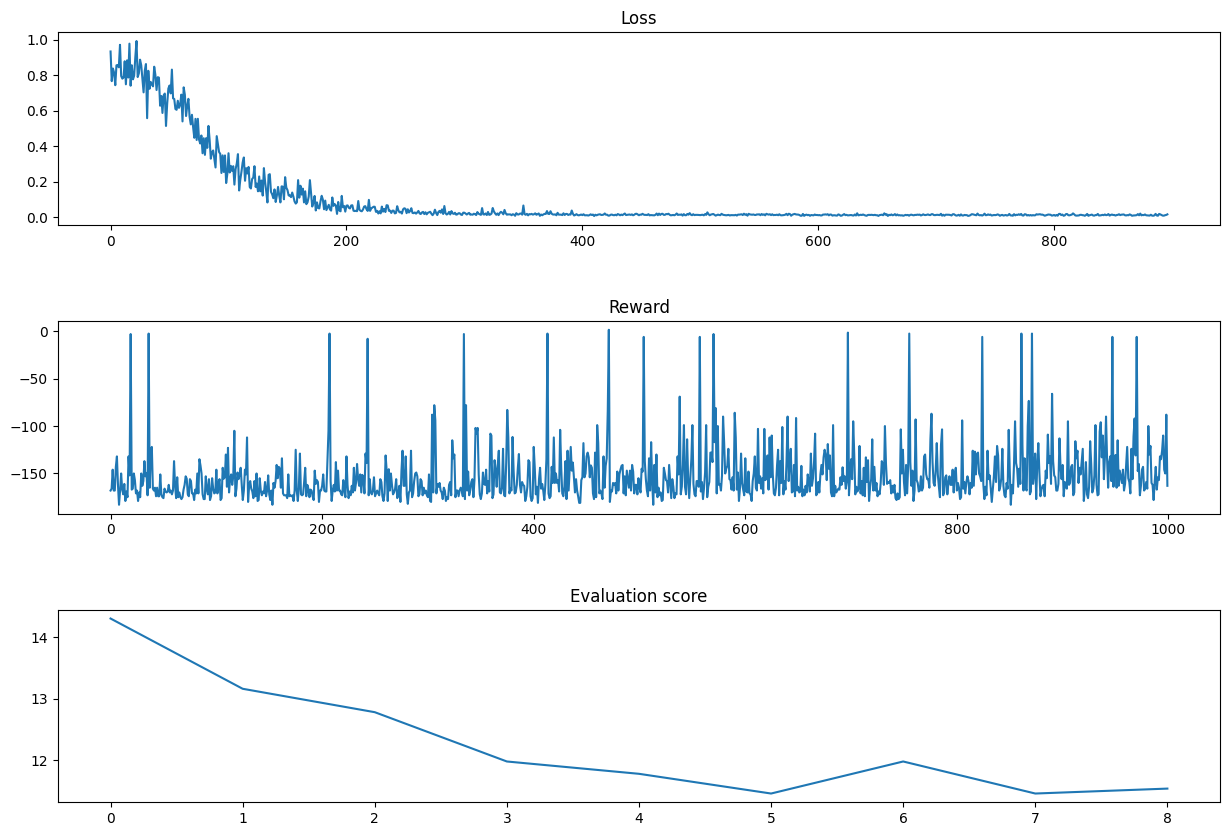

In [ ]:
graph_plots(vars={"Loss":loss, "Reward": all_reward, "Evaluation score": scores})

In [ ]:
evaluate_agent(agent, verbose=True)

Braid 1 of 100: length=6.0 ; rank=2
Braid 2 of 100: length=20.0 ; rank=7
Braid 3 of 100: length=20.0 ; rank=5
Braid 4 of 100: length=18.0 ; rank=3
Braid 5 of 100: length=5.0 ; rank=1
Braid 6 of 100: length=20.0 ; rank=4
Braid 7 of 100: length=12.0 ; rank=2
Braid 8 of 100: length=10.0 ; rank=2
Braid 9 of 100: length=18.0 ; rank=6
Braid 10 of 100: length=10.0 ; rank=4
Braid 11 of 100: length=15.0 ; rank=3
Braid 12 of 100: length=20.0 ; rank=9
Braid 13 of 100: length=8.0 ; rank=4
Braid 14 of 100: length=4.0 ; rank=2
Braid 15 of 100: length=20.0 ; rank=7
Braid 16 of 100: length=1.0 ; rank=1
Braid 17 of 100: length=20.0 ; rank=9
Braid 18 of 100: length=16.0 ; rank=6
Braid 19 of 100: length=20.0 ; rank=6
Braid 20 of 100: length=20.0 ; rank=7
Braid 21 of 100: length=18.0 ; rank=6
Braid 22 of 100: length=4.0 ; rank=2
Braid 23 of 100: length=18.0 ; rank=7
Braid 24 of 100: length=20.0 ; rank=9
Braid 25 of 100: length=20.0 ; rank=6
Braid 26 of 100: length=17.0 ; rank=5
Braid 27 of 100: length=20.

11.54